In [1]:
from typing import List
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from utils import *
from dispatch.utils import *

import dispatch
import importlib
# importlib.reload(dispatch)

from utils import *
# from dispatch.network import ScoringNet, PointEncoder, PositionalEncoder
from networks.encoders import PointEncoder
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator

In [2]:
import gym

class Environment:
    def __init__(self) -> None:
        self.env = gym.make('CartPole-v0')
        self.state = None
        self.reset()

    def reset(self):
        self.state = self.env.reset()

    def step(self, action):
        '''
        returns: reward
        '''
        state, reward, done, info = self.env.step(action)
        self.state = state
        if done:
            self.reset()
            return 0
        return reward

    def get_state(self):
        '''
        returns the copy of state via inherence
        '''
        return self.state

In [3]:
class Policy:
    def __init__(self, model):
        self.model = model

    def estimate_value(self, state):
        inp = torch.tensor(state, dtype=torch.float32)
        return self.model(inp)[1]

    def act(self, state):
        inp = torch.tensor(state, dtype=torch.float32)
        actor, critic = self.model(inp)
    
        # probs = nn.functional.softmax(a, dim=-1).detach().numpy()
        # actions = np.array([np.random.choice(6, p=probs[i]) for i in range(len(inputs))])
        action_probs = nn.functional.softmax(actor, dim=-1)
        action = torch.distributions.Categorical(action_probs).sample()
        # logits = torch.gather(a, dim=1, index=torch.tensor(actions).unsqueeze(-1)).squeeze()

        log_softmaxed = nn.functional.log_softmax(actor, dim=-1)

        # print(log_softmaxed[action.unsqueeze(-1)])
        log_probs = torch.gather(log_softmaxed, dim=-1, index=action.unsqueeze(-1)).squeeze(-1)

        d = {}
        d['actions'] = action
        d['logits'] = actor
        d['log_probs'] = log_probs
        d['values'] = critic

        return d


In [4]:
class TestModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU()
        )
        self.actor = nn.Linear(5, 2)
        self.critic = nn.Linear(5, 1)
    
    def forward(self, x):
        x = self.body(x)
        return self.actor(x), self.critic(x).squeeze(-1)

In [5]:
model = TestModel()
policy = Policy(model)
env = Environment()

d = policy.act(env.get_state())
env.step(d['actions'].item())

[2023-02-10 21:03:31,914] Making new env: CartPole-v0
c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


1.0

In [6]:
from joblib import Parallel, delayed
from collections import defaultdict

class SessionCreater:
    def __init__(self, env, policy, n_steps=4, n_sessions=8, mode='parallel') -> None:
        self.env = env
        self.policy = policy
        self.n_steps = n_steps
        self.n_sessions = n_sessions
        self.mode = mode

    def generate_session(self):
        '''
        output trajectory: dict with keys:
        -states
        -actions
        -rewards

        -logits
        -log_probs
        
        -values
        -advantages
        '''
        trajectory = defaultdict(list)
        self.env.reset()

        for i in range(self.n_steps):
            trajectory['states'].append(self.env.get_state())
            act = self.policy.act(self.env.get_state())

            trajectory['actions'].append(act['actions'])
            trajectory['logits'].append(act['logits'])
            trajectory['log_probs'].append(act['log_probs'])
            trajectory['values'].append(act['values'])

            reward = self.env.step(trajectory["actions"][-1].item())
            trajectory['rewards'].append(reward)

        trajectory['last_state'] = {
            'state': self.env.get_state(),
            'value': self.policy.estimate_value(self.env.get_state())
        }

        return trajectory

    def parallel_generate_sessions(self):
        return Parallel(n_jobs=-1)(delayed(self.generate_session)() for i in range(self.n_sessions))
    
    def sequential_generate_sessions(self):
        return [self.generate_session() for i in range(self.n_sessions)]
    
    def __call__(self):
        if self.mode == 'parallel':
            return self.parallel_generate_sessions()
        return self.sequential_generate_sessions()

In [7]:
def compute_estimated_cumulative_rewards(rewards, last_state_value, gamma=0.99):
    '''
    input: 
    -rewards: List[float] 
    -last_state_q_value: float 
    output: 
    -cum_rewards: List[float]
    '''
    reverse_rewards = [last_state_q_value]
    n_steps = len(rewards)
    for i in range(n_steps, 0, -1):
        reverse_rewards.append(reverse_rewards[-1] * gamma + rewards[i - 1])
    return reverse_rewards[1:][::-1]

In [8]:
class ComputeValueTargets:
    def __init__(self, gamma=0.99):
        self.gamma = gamma

    def compute_cumutitive_rewards(self, rewards, last_state_value):
        reverse_rewards = [last_state_value]
        n_steps = len(rewards)
        for i in range(n_steps, 0, -1):
            reverse_rewards.append(reverse_rewards[-1] * self.gamma + rewards[i - 1])
        return reverse_rewards[1:][::-1]
    
    def __call__(self, session):
        for trajectory in session:
            rewards = trajectory['rewards']
            last_state_value = trajectory['last_state']['value']
            trajectory['targets'] = self.compute_cumutitive_rewards(rewards, last_state_value)

In [10]:
cvt = ComputeValueTargets()
s = SessionCreater(env, policy, mode='def')
trs = s()
cvt(trs)
trs[0]

defaultdict(list,
            {'states': [array([-0.03555699, -0.02499039,  0.00473004,  0.01856952]),
              array([-0.03605679, -0.22017985,  0.00510143,  0.31274107]),
              array([-0.04046039, -0.02513094,  0.01135625,  0.02167133]),
              array([-0.04096301,  0.16982632,  0.01178968, -0.26740704])],
             'actions': [tensor(0), tensor(1), tensor(1), tensor(0)],
             'logits': [tensor([-4.1165e-01, -1.1660e-04], grad_fn=<AddBackward0>),
              tensor([-0.4294, -0.0023], grad_fn=<AddBackward0>),
              tensor([-0.4124, -0.0007], grad_fn=<AddBackward0>),
              tensor([-0.3986, -0.0016], grad_fn=<AddBackward0>)],
             'log_probs': [tensor(-0.9199, grad_fn=<SqueezeBackward1>),
              tensor(-0.5022, grad_fn=<SqueezeBackward1>),
              tensor(-0.5083, grad_fn=<SqueezeBackward1>),
              tensor(-0.9113, grad_fn=<SqueezeBackward1>)],
             'values': [tensor(0.2142, grad_fn=<SqueezeBackward1>),


In [123]:
def merge_time_batch(sessions):
    keys = [k for k in sessions[0].keys() if k != 'last_state']
    result = {}
    for key in keys:
        result[key] = torch.hstack([s[key] for s in sessions])

    return result

In [125]:
merge_time_batch(trs)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [8]:
def convert_sessions_to_tensors(trajectory):
    # trajectory['targets'] = compute_estimated_cumulative_rewards(trajectory['rewards'], trajectory['last_state']['q_value'])
    for k, v in trajectory.items():
        pass

def compute_losses():
    '''
    input:
    -
    output: 
    -policy_loss 
    -value_loss (V = G) 
    -entropy_loss
    '''
    pass

In [8]:
class A:
    def __init__(self, x) -> None:
        self.x = x

    def incr(self):
        self.x += 1

    def __repr__(self) -> str:
        return str(self.x)

def create(smth, arg):
    return smth(arg)

In [9]:
a = create(A, 0)
a.incr()
b = create(A, 0)
print(a, b)

1 0


In [10]:
d = A

In [1]:
import numpy as np # used for arrays

import time # to get the time
import math # needed for calculations

In [11]:
env = gym.make("CartPole-v1")
print(env.action_space.n)

[2023-04-01 16:28:52,549] Making new env: CartPole-v1


2


c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
env.reset()

array([-0.02520949, -0.0479926 ,  0.02926615, -0.01972681])

In [5]:
env.reset()
for i in range(100):
    state, reward, done, info = env.step(1)
    if done:
        print('done', i)
        break

done 8


: 

In [25]:
import gym
import numpy as np
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.f(x)

class ActorCartPole:
    def __init__(self, net) -> None:
        self.net = net

    def __call__(self, state):
        state = torch.tensor(state, dtype=torch.float)
        action_probs = nn.functional.softmax(self.net(state)).detach().numpy()
        action = np.random.choice([0, 1], size=None, p=action_probs)
        return action

class EnvCartPole:
    def __init__(self, actor) -> None:
        self.env = gym.make("CartPole-v1")
        self.actor = actor
        self.state = self.env.reset()
        self.reward = 0

    def Next(self):
        action = self.actor(self.state)
        self.state, self.reward, done, info = self.env.step(action)
        if done:
            self.reward -= 10
            self.state = self.env.reset()

    def GetState(self):
        return self.state
    
    def GetReward(self):
        return self.reward

In [1]:
from reinforcement.cartpole import EnvCartPole, MLP, ActorCartPole

In [7]:
from itertools import accumulate
import numpy as np

gamma = 0.99
rewards = np.random.randn(10)
session = [{'reward': r} for r in rewards]
# rewards = [s['reward'] for s in session]
cumulative_rewards = list(accumulate(rewards[::-1], lambda x,y: x*gamma + y))[::-1]
v_last = 0
for i in range(len(rewards))[::-1]:
    v_last = v_last * gamma + session[i]['reward']
    session[i]['cum_reward'] = v_last

for a, b in zip(cumulative_rewards, session):
    print(a - b['cum_reward'])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
import torch
a = torch.tensor([1, 10, 100])
b = torch.tensor([1, 10, 100])
torch.tensor([[1.0], [2.0]]).squeeze(1)

tensor([1., 2.])

In [1]:
from reinforcement.A2C import A2C
from reinforcement.cartpole import EnvCartPole, MLP, ActorCartPole
import torch
from tqdm import tqdm
import numpy as np

In [2]:
mode = 'MountainCar-v0'
net = MLP(mode=mode)
actor = ActorCartPole
env = EnvCartPole
opt = torch.optim.Adam(net.parameters())
a2c = A2C(env, actor, net, opt, n_steps=5, n_sessions=10, mode=mode, value_loss_coef=0.001, regularization_loss_coef=10.0)

[2023-04-03 00:05:15,752] Making new env: MountainCar-v0
c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\envs\registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
[2023-04-03 00:05:15,786] Making new env: MountainCar-v0
[2023-04-03 00:05:15,789] Making new env: MountainCar-v0
[2023-04-03 00:05:15,792] Making new env: MountainCar-v0
[2023-04-03 00:05:15,794] Making new env: MountainCar-v0
[2023-04-03 00:05:15,796] Making new env: MountainCar-v0
[2023-04-03 00:05:15,797] Making new env: MountainCar-v0
[2023-04-03 00:05:15,799] Making new env: MountainCar-v0
[2023-04-03 00:05:15,801] Making new env: MountainCar-v0
[2023-04-03 00:05:15,804] Making new env: MountainCar-v0


100%|██████████| 10000/10000 [06:11<00:00, 26.93it/s]


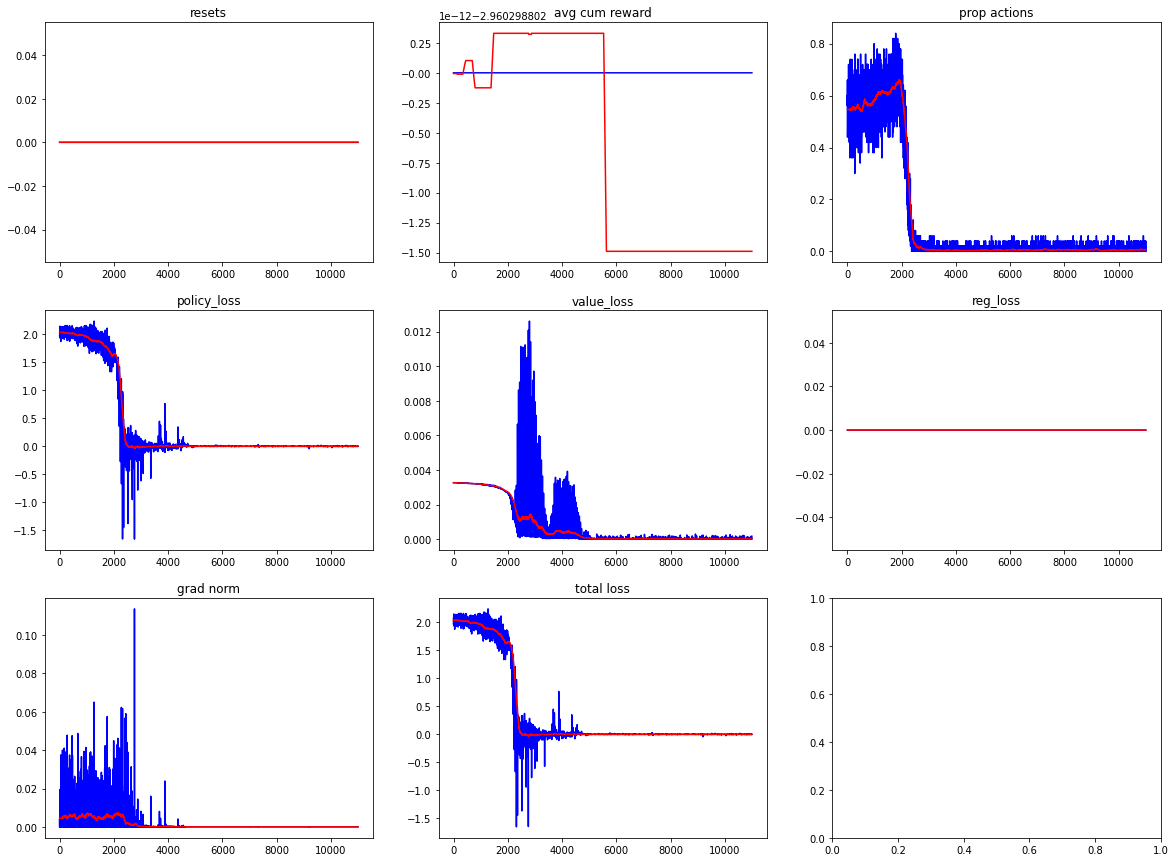

In [4]:
for i in tqdm(range(10000)):
    a2c.train_step()
a2c.logger.plot(100, log_scale=False)

In [5]:
1 / (np.mean(a2c.logger.logs['resets'][-100:]) / a2c.n_sessions / a2c.n_steps)

c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

In [5]:
[s for s in a2c.logger.logs_mute['step info'][-10:]]

[{'state': array([-0.90340129, -0.00573502]),
  'reward': -1.0,
  'action': 0,
  'step': 0,
  'cum_reward': -4.90099501},
 {'state': array([-0.90786535, -0.00446406]),
  'reward': -1.0,
  'action': 0,
  'step': 1,
  'cum_reward': -3.9403989999999998},
 {'state': array([-0.91104465, -0.0031793 ]),
  'reward': -1.0,
  'action': 0,
  'step': 2,
  'cum_reward': -2.9701},
 {'state': array([-0.91292962, -0.00188496]),
  'reward': -1.0,
  'action': 0,
  'step': 3,
  'cum_reward': -1.99},
 {'state': array([-9.13514666e-01, -5.85050350e-04]),
  'reward': -1.0,
  'action': 0,
  'step': 4,
  'cum_reward': -1.0},
 {'state': array([-0.92638285, -0.00689053]),
  'reward': -1.0,
  'action': 0,
  'step': 0,
  'cum_reward': -4.90099501},
 {'state': array([-0.93193579, -0.00555294]),
  'reward': -1.0,
  'action': 0,
  'step': 1,
  'cum_reward': -3.9403989999999998},
 {'state': array([-0.93613671, -0.00420092]),
  'reward': -1.0,
  'action': 0,
  'step': 2,
  'cum_reward': -2.9701},
 {'state': array([-0.

In [8]:
a = torch.tensor([0., 1.], requires_grad=True)
b = a
l = (a**2).sum()
l.backward()
b.grad